# Week 9 - Neural Machine Translation (NMT) using Encoder-Decoder with attention and transformer mechanism.
# October 19, 2023.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
import tensorflow as tf
import pickle as pkl
import numpy as np

In [3]:
with open('kan.txt','r') as f:
    data = f.readlines()

In [4]:
data

["What's up?\tಆರಾಮಾ?\tCC-BY 2.0 (France) Attribution: tatoeba.org #25164 (CK) & #8902986 (satez416)\n",
 'How are you?\tಹೇಗಿದ್ದೀರ\tCC-BY 2.0 (France) Attribution: tatoeba.org #373320 (CK) & #8902982 (satez416)\n',
 'Tom woke up.\tಟಾಮ್ ಏಳಿದನು.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2240217 (CK) & #4776457 (legalghost)\n',
 'Give me half.\tಅರ್ಧ ನನಗೆ ಕೊಡು.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2043700 (CK) & #4776542 (legalghost)\n',
 'We needed it.\tನಮಗೆ ಬೇಕಾಗಿತ್ತು.\tCC-BY 2.0 (France) Attribution: tatoeba.org #4501171 (CK) & #4784813 (legalghost)\n',
 "I'm very busy.\tನಾನು ತುಂಬಾ ಬಿಝಿ\tCC-BY 2.0 (France) Attribution: tatoeba.org #433991 (CK) & #8902992 (satez416)\n",
 'Tom liked you.\tಟಾಮ್ ನಿನ್ನನ್ನು ಬಯಸಿದನು.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2237161 (CK) & #4776861 (legalghost)\n',
 'Just go inside.\tಒಳಗೆ ಹೋಗು ಅಷ್ಟೇ.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2249423 (CK) & #4774747 (legalghost)\n',
 'Do you remember?\tನಿಮಗೆ ನೆನಪು ಇದ್ಯಾ?\tCC-BY 2.0 (France) 

In [5]:
print("The length of the data:",len(data))

The length of the data: 158


In [6]:
english_word = []
kannada_word = []
cleaned_data_list = []
for word in data:
  english_word.append(word.split('\t')[:-1][0])
  kannada_word.append(word.split('\t')[:-1][1])
language_data = pd.DataFrame(columns=['English','Kannada'])
language_data['English'] = english_word
language_data['Kannada'] = kannada_word
language_data.to_csv('language_data.csv', index=False)

In [7]:
language_data.head()

,English,Kannada
0,What's up?,ಆರಾಮಾ?
1,How are you?,ಹೇಗಿದ್ದೀರ
2,Tom woke up.,ಟಾಮ್ ಏಳಿದನು.
3,Give me half.,ಅರ್ಧ ನನಗೆ ಕೊಡು.
4,We needed it.,ನಮಗೆ ಬೇಕಾಗಿತ್ತು.


In [24]:
english_text = language_data['English'].values
kannada_text = language_data['Kannada'].values
print("Number of samples in English text:",len(english_text))
print("Number of samples in Kannada text:",len(kannada_text))

Number of samples in English text: 158
Number of samples in Kannada text: 158


## 1. Perform required text pre-processing


In [25]:
#to lower case
english_text_ = [x.lower() for x in english_text]
kannada_text_ = [x.lower() for x in kannada_text]
#removing inverted commas
english_text_ = [re.sub("'",'',x) for x in english_text_]
kannada_text_ = [re.sub("'",'',x) for x in kannada_text_]
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
kannada_text_ = remove_punc(kannada_text_)
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text
# removing the digits from the kannada sentances
kannada_text_ = [re.sub("[೧೨೩೪೫೬೭೮೯೦]","",x) for x in kannada_text_]
kannnada_text_ = [re.sub("[\u200d]","",x) for x in kannada_text_]
# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
kannada_text_ = [x.strip() for x in kannada_text_]

In [26]:
# Adding ‘start’ and ‘end’ tag to kannada sentence.
# This will help the decoder to know from where to start decoding and when to end.
kannada_text_ = ["start " + x + " end" for x in kannada_text_]
# manipulated_kannada_text_
kannada_text_[0], english_text_[0]

('start ಆರಾಮಾ end', 'whats up')

In [27]:
X = english_text_
Y = kannada_text_
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.1)

In [28]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_
#Training data
max_length_english = Max_length(X_train)
max_length_kannada = Max_length(y_train)
#Test data
max_length_english_test = Max_length(X_test)
max_length_kannada_test = Max_length(y_test)
print("Maximum length of Kannada sentence:",max_length_kannada)
print("Maximum length of English sentence:",max_length_english)

Maximum length of Kannada sentence: 11
Maximum length of English sentence: 15


In [29]:
# Tokenizing both english and kannada text
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1
X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')
X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')
kannadaTokenizer = Tokenizer()
kannadaTokenizer.fit_on_texts(y_train)
Kword2index = kannadaTokenizer.word_index
vocab_size_target = len(Kword2index) + 1
y_train = kannadaTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_kannada, padding='post')
y_test = kannadaTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_kannada, padding='post')
print("Vocabulary size of source (english):",vocab_size_source)
print("Vocabulary size of target (Kannada):",vocab_size_target)

Vocabulary size of source (english): 386
Vocabulary size of target (Kannada): 440


In [30]:
# Creating train and test splits
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## 2. Train and test the encode-decoder model with attention mechanism.


In [58]:
# Attention Mechanism
class AttentionLayer(tf.keras.layers.Layer):
  def __init__(self, units):
    super(AttentionLayer, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # values shape == (batch_size, max_len, hidden size)

    # we are doing this to broadcast addition along the time axis to calculate the score
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [59]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

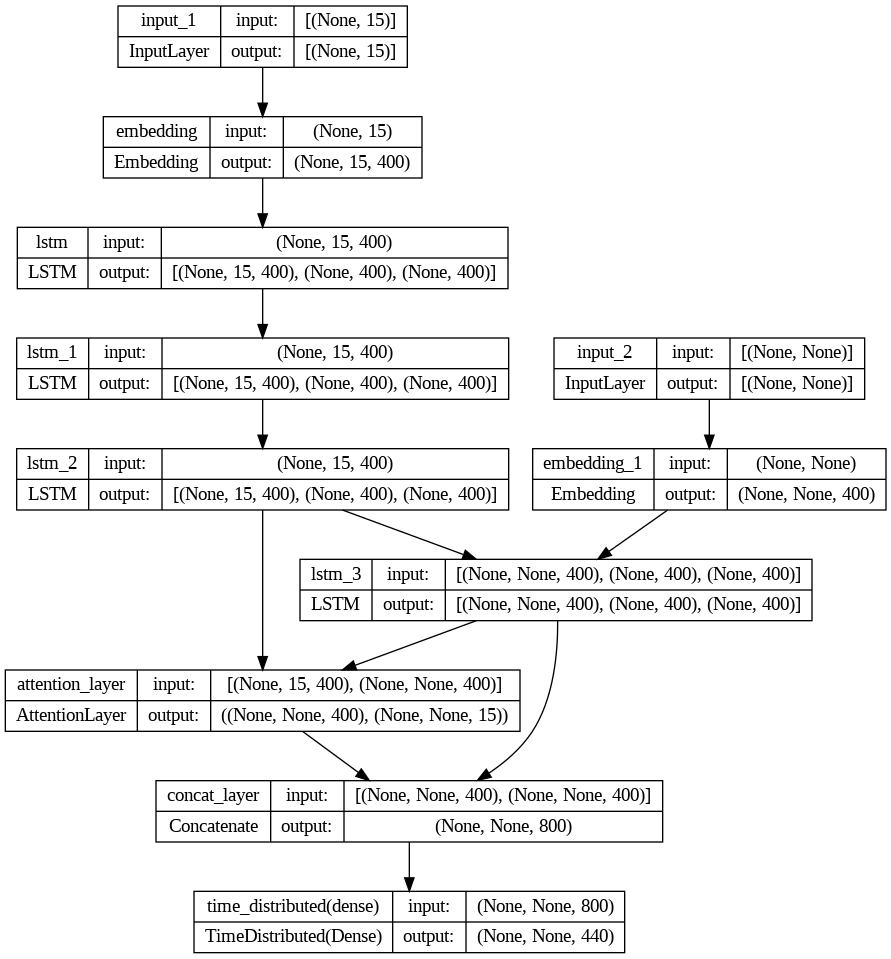

In [60]:
from keras import backend as K
K.clear_session()
latent_dim = 400
# Encoder
encoder_inputs = Input(shape=(max_length_english,))
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs)
# LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
# Attention Layer
attn_layer = AttentionLayer()
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Plot the model
plot_model(model, to_file='train_model.png', show_shapes=True)

In [61]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [62]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],epochs=100,batch_size=128,validation_data = ([X_test, y_test[:,:-1]],y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/100
2/2 [==============================] - 10s 2s/step - loss: 6.0778 - accuracy: 0.0437 - val_loss: 5.7544 - val_accuracy: 0.7250
Epoch 2/100
2/2 [==============================] - 0s 179ms/step - loss: 5.8827 - accuracy: 0.4444 - val_loss: 3.3016 - val_accuracy: 0.7250
Epoch 3/100
2/2 [==============================] - 0s 193ms/step - loss: 4.5607 - accuracy: 0.4444 - val_loss: 2.7684 - val_accuracy: 0.7312
Epoch 4/100
2/2 [==============================] - 1s 354ms/step - loss: 3.7019 - accuracy: 0.4472 - val_loss: 1.6022 - val_accuracy: 0.7563
Epoch 5/100
2/2 [==============================] - 1s 218ms/step - loss: 3.2453 - accuracy: 0.4451 - val_loss: 1.8117 - val_accuracy: 0.7312
Epoch 6/100
2/2 [==============================] - 1s 244ms/step - loss: 3.1876 - accuracy: 0.4542 - val_loss: 1.7843 - val_accuracy: 0.6938
Epoch 7/100
2/2 [==============================] - 1s 225ms/step - loss: 3.1281 - accuracy: 0.4627 - val_loss: 1.6647 - val_accuracy: 0.7063
Epoch 8/100
2/2

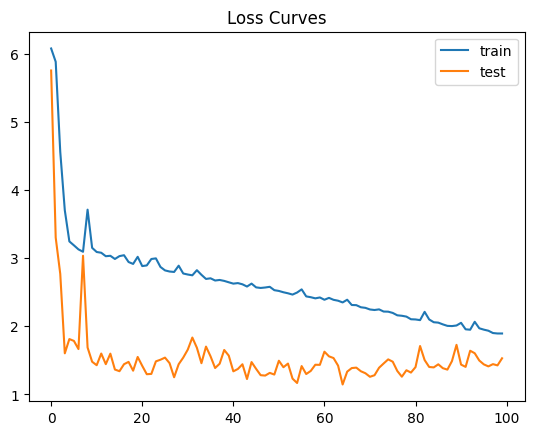

In [63]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title("Loss Curves")
pyplot.legend()
pyplot.show()

In [64]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [65]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

In [66]:
latent_dim=400
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs
#print(encoder_outputs.shape)
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(15,latent_dim))
# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output
#print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [67]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Choose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Kword2index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index == 0:
            break
        else:
            sampled_token = Kindex2word[sampled_token_index]
            if sampled_token != 'end':
                decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [68]:
Eindex2word = englishTokenizer.index_word
Kindex2word = kannadaTokenizer.index_word

In [69]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Kword2index['start']) and i!=Kword2index['end']):
        newString=newString+Kindex2word[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

In [70]:
for i in range(10):
  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print(X_test[i].shape)
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,15)))
  print("\n")

Review: i dont know how i can ever you 
Original summary: ನಿಮಗೆ ಹೇಗೆ ಇಲ್ಲ 
(15,)
1/1 [==============================] - 0s 37ms/step
Predicted summary:  ನಾನು ನಿಮಗೆ ಅವನನ್ನು ಎಂದು


Review: i sure that no one was 
Original summary: ನಾನು 
(15,)
1/1 [==============================] - 0s 33ms/step
Predicted summary:  ನಾನು ರಾತ್ರಿ ಹೇಗೆ


Review: tom 
Original summary: ಟಾಮ್ 
(15,)
1/1 [==============================] - 0s 34ms/step
Predicted summary:  ಟಾಮ್ ಈಗ


Review: tom the was 
Original summary: ಟಾಮಿಗೆ ಅಂತ 
(15,)
1/1 [==============================] - 0s 24ms/step
Predicted summary:  ಟಾಮ್ ಈಗ


Review: you be in two at 
Original summary: ನಿಮಗೆ ಎರಡು ಇರುವುದಕ್ಕೆ 
(15,)
1/1 [==============================] - 0s 27ms/step
Predicted summary:  ನಾನು ರಾತ್ರಿ ಹೇಗೆ


Review: my that you were 
Original summary: ನಿನ್ನನ್ನು ಮತ್ತು ತಪ್ಪು 
(15,)
1/1 [==============================] - 0s 23ms/step
Predicted summary:  ಅವಳು ನನ್ನ ಅಭಿಪ್ರಾಯವನ್ನು


Review: we were caught in a 
Original summary: ನಾವು 
(15,)
1/1 [=====